# 迁移学习 Transfer Learning

Most of the time you won't want to train a whole convolutional network yourself. Modern ConvNets training on huge datasets like ImageNet take weeks on multiple GPUs. Instead, most people use a pretrained network either as a fixed feature extractor, or as an initial network to fine tune. In this notebook, you'll be using [VGGNet](https://arxiv.org/pdf/1409.1556.pdf) trained on the [ImageNet dataset](http://www.image-net.org/) as a feature extractor. Below is a diagram of the VGGNet architecture.

大多数时候你不想自己训练一个完整的卷积网络。 现代ConvNets对巨大数据集（如ImageNet）的训练在多个GPU上花费数周时间。 相反，大多数人使用预训练网络作为固定特征提取器，或作为初始网络进行微调。 在这本notebook中，您将使用[ImageNet数据集](http://www.image-net.org/)上训练的[VGGNet](https://arxiv.org/pdf/1409.1556.pdf)作为 特征提取器 以下是VGGNet架构图。

<img src="assets/cnnarchitecture.jpg" width=700px>

VGGNet is great because it's simple and has great performance, coming in second in the ImageNet competition. The idea here is that we keep all the convolutional layers, but replace the final fully connected layers with our own classifier. This way we can use VGGNet as a feature extractor for our images then easily train a simple classifier on top of that. What we'll do is take the first fully connected layer with 4096 units, including thresholding with ReLUs. We can use those values as a code for each image, then build a classifier on top of those codes.

VGGNet是伟大的，因为它很简单，性能很好，在ImageNet大赛中排名第二。 这里的想法是，我们保留所有的卷积层，而是用我们自己的分类器来代替最终完全连接的层。 这样，我们可以使用VGGNet作为我们图像的特征提取器，然后轻松地训练一个简单的分类器。 我们要做的是将第一个完全连接的层与4096个单元，包括使用ReLUs进行阈值处理。 我们可以使用这些值作为每个图像的代码，然后在这些代码之上构建一个分类器。

You can read more about transfer learning from [the CS231n course notes](http://cs231n.github.io/transfer-learning/#tf).

您可以从[CS231n课程笔记](http://cs231n.github.io/transfer-learning/#tf) 阅读更多关于转学习的信息。

## VGGNet 预训练模型 Pretrained VGGNet

We'll be using a pretrained network from https://github.com/machrisaa/tensorflow-vgg. Make sure to clone this repository to the directory you're working from. You'll also want to rename it so it has an underscore instead of a dash.

我们将使用https://github.com/machrisaa/tensorflow-vgg 中的预训练网络。 确保将该存储库clone到您正在工作的目录。 您还需要重命名它，因此它具有下划线而不是破折号。

```
git clone https://github.com/machrisaa/tensorflow-vgg.git tensorflow_vgg
```

This is a really nice implementation of VGGNet, quite easy to work with. The network has already been trained and the parameters are available from this link. **You'll need to clone the repo into the folder containing this notebook.** Then download the parameter file using the next cell.

这是一个非常好的VGGNet实现，很容易使用。 该网络已经受过训练，并且可以从此链接获得参数。 **您需要将repo克隆到包含此笔记本的文件夹中。**然后使用下一个单元格下载参数文件。

In [1]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm

vgg_dir = 'tensorflow_vgg/'
# Make sure vgg exists
if not isdir(vgg_dir):
    raise Exception("VGG directory doesn't exist!")

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(vgg_dir + "vgg16.npy"):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='VGG16 Parameters') as pbar:
        urlretrieve(
            'https://s3.amazonaws.com/content.udacity-data.com/nd101/vgg16.npy',
            vgg_dir + 'vgg16.npy',
            pbar.hook)
else:
    print("Parameter file already exists!")

Parameter file already exists!


## 花朵识别  Flower power

Here we'll be using VGGNet to classify images of flowers. To get the flower dataset, run the cell below. This dataset comes from the [TensorFlow inception tutorial](https://www.tensorflow.org/tutorials/image_retraining).

在这里，我们将使用VGGNet对花的图像进行分类。 要获取花数据集，请运行下面的单元格。 此数据集来自[TensorFlow入门教程](https://www.tensorflow.org/tutorials/image_retraining)。

In [3]:
import tarfile

dataset_folder_path = 'flower_photos'

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile('flower_photos.tar.gz'):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='Flowers Dataset') as pbar:
        urlretrieve(
            'http://download.tensorflow.org/example_images/flower_photos.tgz',
            'flower_photos.tar.gz',
            pbar.hook)

if not isdir(dataset_folder_path):
    with tarfile.open('flower_photos.tar.gz') as tar:
        tar.extractall()
        tar.close()
print("done")

done


## ConvNet Codes

Below, we'll run through all the images in our dataset and get codes for each of them. That is, we'll run the images through the VGGNet convolutional layers and record the values of the first fully connected layer. We can then write these to a file for later when we build our own classifier.

下面，我们将运行数据集中的所有图像，并为每个图像获取代码。 也就是说，我们将通过VGGNet卷积图层运行图像，并记录第一个完全连接的图层的值。 然后，当我们构建自己的分类器时，我们可以将这些文件写入文件中。

Here we're using the `vgg16` module from `tensorflow_vgg`. The network takes images of size $224 \times 224 \times 3$ as input. Then it has 5 sets of convolutional layers. The network implemented here has this structure (copied from [the source code](https://github.com/machrisaa/tensorflow-vgg/blob/master/vgg16.py)):

这里我们使用`tensorflow_vgg`的`vgg16`模块。 网络拍摄尺寸为 $224 \times 224 \times 3$ 的图像作为输入。 然后它有5组卷积层。 这里实现的网络具有此结构（从[源代码](https://github.com/machrisaa/tensorflow-vgg/blob/master/vgg16.py)复制）：

```
self.conv1_1 = self.conv_layer(bgr, "conv1_1")
self.conv1_2 = self.conv_layer(self.conv1_1, "conv1_2")
self.pool1 = self.max_pool(self.conv1_2, 'pool1')

self.conv2_1 = self.conv_layer(self.pool1, "conv2_1")
self.conv2_2 = self.conv_layer(self.conv2_1, "conv2_2")
self.pool2 = self.max_pool(self.conv2_2, 'pool2')

self.conv3_1 = self.conv_layer(self.pool2, "conv3_1")
self.conv3_2 = self.conv_layer(self.conv3_1, "conv3_2")
self.conv3_3 = self.conv_layer(self.conv3_2, "conv3_3")
self.pool3 = self.max_pool(self.conv3_3, 'pool3')

self.conv4_1 = self.conv_layer(self.pool3, "conv4_1")
self.conv4_2 = self.conv_layer(self.conv4_1, "conv4_2")
self.conv4_3 = self.conv_layer(self.conv4_2, "conv4_3")
self.pool4 = self.max_pool(self.conv4_3, 'pool4')

self.conv5_1 = self.conv_layer(self.pool4, "conv5_1")
self.conv5_2 = self.conv_layer(self.conv5_1, "conv5_2")
self.conv5_3 = self.conv_layer(self.conv5_2, "conv5_3")
self.pool5 = self.max_pool(self.conv5_3, 'pool5')

self.fc6 = self.fc_layer(self.pool5, "fc6")
self.relu6 = tf.nn.relu(self.fc6)
```

So what we want are the values of the first fully connected layer, after being ReLUd (`self.relu6`). To build the network, we use

所以我们想要的是第一个完全连接的层的值，在ReLUd(`self.relu6`)之后。 建立网络，我们使用

```
with tf.Session() as sess:
    vgg = vgg16.Vgg16()
    input_ = tf.placeholder(tf.float32, [None, 224, 224, 3])
    with tf.name_scope("content_vgg"):
        vgg.build(input_)
```

This creates the `vgg` object, then builds the graph with `vgg.build(input_)`. Then to get the values from the layer,

这将创建`vgg`对象，然后用`vgg.build（input_）`构建图。 然后从图层获取值，

```
feed_dict = {input_: images}
codes = sess.run(vgg.relu6, feed_dict=feed_dict)
```

In [4]:
import os

import numpy as np
import tensorflow as tf

from tensorflow_vgg import vgg16
from tensorflow_vgg import utils

In [5]:
data_dir = 'flower_photos/'
contents = os.listdir(data_dir)
classes = [each for each in contents if os.path.isdir(data_dir + each)]
print(classes)

['tulips', 'roses', 'dandelion', 'daisy', 'sunflowers']


Below I'm running images through the VGG network in batches.

下面我分批通过VGG网络运行图像。

> **Exercise:** Below, build the VGG network. Also get the codes from the first fully connected layer (make sure you get the ReLUd values).

> **练习：** 下面，构建VGG网络。 还可以从第一个完全连接的层获取代码（确保您获得ReLUd值）。

In [7]:
# Set the batch size higher if you can fit in in your GPU memory
batch_size = 10
codes_list = []
labels = []
batch = []

codes = None

with tf.Session() as sess:
    
    # TODO: Build the vgg network here
    vgg = vgg16.Vgg16()
    input_ = tf.placeholder(tf.float32, [None,224,224,3])
    with tf.name_scope("content_vgg"):
        vgg.build(input_)

    for each in classes:
        print("Starting {} images".format(each))
        class_path = data_dir + each
        files = os.listdir(class_path)
        for ii, file in enumerate(files, 1):
            # Add images to the current batch
            # utils.load_image crops the input images for us, from the center
            img = utils.load_image(os.path.join(class_path, file))
            batch.append(img.reshape((1, 224, 224, 3)))
            labels.append(each)
            
            # Running the batch through the network to get the codes
            if ii % batch_size == 0 or ii == len(files):
                
                # Image batch to pass to VGG network
                images = np.concatenate(batch)
                
                # TODO: Get the values from the relu6 layer of the VGG network
                codes_batch = sess.run(vgg.relu6, feed_dict={input_: images})
                
                # Here I'm building an array of the codes
                if codes is None:
                    codes = codes_batch
                else:
                    codes = np.concatenate((codes, codes_batch))
                
                # Reset to start building the next batch
                batch = []
                print('{} images processed'.format(ii))
print("Done")

/home/jidou/mygithub/dlnd_transfer-learning/tensorflow_vgg/vgg16.npy
npy file loaded
build model started
build model finished: 0s
Starting tulips images
10 images processed
20 images processed
30 images processed
40 images processed
50 images processed
60 images processed
70 images processed
80 images processed
90 images processed
100 images processed
110 images processed
120 images processed
130 images processed
140 images processed
150 images processed
160 images processed
170 images processed
180 images processed
190 images processed
200 images processed
210 images processed
220 images processed
230 images processed
240 images processed
250 images processed
260 images processed
270 images processed
280 images processed
290 images processed
300 images processed
310 images processed
320 images processed
330 images processed
340 images processed
350 images processed
360 images processed
370 images processed
380 images processed
390 images processed
400 images processed
410 images proce

In [10]:
# write codes to file
with open('codes', 'w') as f:
    codes.tofile(f)
    print("write codes to file")
    
# write labels to file
import csv
with open('labels', 'w') as f:
    writer = csv.writer(f, delimiter='\n')
    writer.writerow(labels)
    print("write labels to file")

write codes to file
write labels to file


## 构建分类器 Building the Classifier

Now that we have codes for all the images, we can build a simple classifier on top of them. The codes behave just like normal input into a simple neural network. Below I'm going to have you do most of the work.

现在我们有所有图像的代码，我们可以在它们之上构建一个简单的分类器。 代码的行为就像普通输入到一个简单的神经网络。 下面我要做大部分的工作。

In [12]:
# read codes and labels from file
import csv

with open('labels') as f:
    reader = csv.reader(f, delimiter='\n')
    labels = np.array([each for each in reader if len(each) > 0]).squeeze()
with open('codes') as f:
    codes = np.fromfile(f, dtype=np.float32)
    codes = codes.reshape((len(labels), -1))
print("lables.shape={} codes.shape={}".format(labels.shape, codes.shape))

lables.shape=(3670,) codes.shape=(3670, 4096)


### 数据准备 Data prep

As usual, now we need to one-hot encode our labels and create validation/test sets. First up, creating our labels!

像往常一样，现在我们需要对我们的标签进行one-hot编码，并创建验证/测试集。 首先，创建我们的标签！

> **Exercise:** From scikit-learn, use [LabelBinarizer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelBinarizer.html) to create one-hot encoded vectors from the labels. 

> **练习：**从scikit学习，使用 [LabelBinarizer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelBinarizer.html) 创建一个热编码向量从 标签。

In [14]:
from sklearn import preprocessing

lb = preprocessing.LabelBinarizer()
labels_vecs = lb.fit_transform(labels) # Your one-hot encoded labels array here
print("labels_vecs.shape=", labels_vecs.shape)

labels_vecs.shape= (3670, 5)


Now you'll want to create your training, validation, and test sets. An important thing to note here is that our labels and data aren't randomized yet. We'll want to shuffle our data so the validation and test sets contain data from all classes. Otherwise, you could end up with testing sets that are all one class. Typically, you'll also want to make sure that each smaller set has the same the distribution of classes as it is for the whole data set. The easiest way to accomplish both these goals is to use [`StratifiedShuffleSplit`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html) from scikit-learn.

现在，您将要创建您的训练，验证和测试集。 这里要注意的一个重要事情是，我们的标签和数据尚未随机化。 我们将要洗牌我们的数据，所以验证和测试集包含所有类的数据。 否则，您可能会得到所有类的测试集。 通常，您还需要确保每个较小的集合具有与整个数据集相同的类的分布。 完成这两个目标的最简单方法是使用[`stratifiedShuffleSplit`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html) 从scikit-learn。

You can create the splitter like so:

你可以像这样创建分割器：
```
ss = StratifiedShuffleSplit(n_splits=1, test_size=0.2)
```
Then split the data with 

然后将数据分割为
```
splitter = ss.split(x, y)
```

`ss.split` returns a generator of indices. You can pass the indices into the arrays to get the split sets. The fact that it's a generator means you either need to iterate over it, or use `next(splitter)` to get the indices. Be sure to read the [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html) and the [user guide](http://scikit-learn.org/stable/modules/cross_validation.html#random-permutations-cross-validation-a-k-a-shuffle-split).

`ss.split`返回一个索引生成器。 您可以将索引传递到数组以获取拆分集。 事实上，它是一个生成器意味着您需要迭代它，或使用 `next（splitter） `获取索引。 请务必阅读[文档](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html)和[用户指南](http://scikit-learn.org/#random-permutations-cross-validation-a-k-a-shuffle-split) 。

> **Exercise:** Use StratifiedShuffleSplit to split the codes and labels into training, validation, and test sets.

> **练习：**使用StratifiedShuffleSplit将代码和标签拆分为训练，验证和测试集。

In [23]:
from sklearn.model_selection import StratifiedShuffleSplit
ss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=32)
train_idx, val_idx = next(ss.split(codes, labels_vecs))
val_idx, test_idx = val_idx[:len(val_idx)//2], val_idx[len(val_idx)//2:]

train_x, train_y = codes[train_idx], labels_vecs[train_idx]
val_x, val_y =  codes[val_idx], labels_vecs[val_idx]
test_x, test_y =   codes[test_idx], labels_vecs[test_idx]

print("Train shapes (x, y):", train_x.shape, train_y.shape)
print("Validation shapes (x, y):", val_x.shape, val_y.shape)
print("Test shapes (x, y):", test_x.shape, test_y.shape)

Train shapes (x, y): (2936, 4096) (2936, 5)
Validation shapes (x, y): (367, 4096) (367, 5)
Test shapes (x, y): (367, 4096) (367, 5)


If you did it right, you should see these sizes for the training sets:

如果你做的对，你应该看到训练集的这些大小：

```
Train shapes (x, y): (2936, 4096) (2936, 5)
Validation shapes (x, y): (367, 4096) (367, 5)
Test shapes (x, y): (367, 4096) (367, 5)
```

### 分类器层 Classifier layers

Once you have the convolutional codes, you just need to build a classfier from some fully connected layers. You use the codes as the inputs and the image labels as targets. Otherwise the classifier is a typical neural network.

一旦你有卷积码，你只需要从一些完全连接的层构建一个分类器。 您将代码用作输入和图像标签作为目标。 否则，分类器是典型的神经网络。

> **Exercise:** With the codes and labels loaded, build the classifier. Consider the codes as your inputs, each of them are 4096D vectors. You'll want to use a hidden layer and an output layer as your classifier. Remember that the output layer needs to have one unit for each class and a softmax activation function. Use the cross entropy to calculate the cost.

> **练习：**加载代码和标签，构建分类器。 将代码视为您的输入，每个代码都是4096D向量。 您将要使用隐藏层和输出层作为分类器。 请记住，输出层需要为每个类设置一个单位和一个softmax激活功能。 使用交叉熵计算成本。

In [68]:
inputs_ = tf.placeholder(tf.float32, shape=[None, codes.shape[1]])
labels_ = tf.placeholder(tf.int64, shape=[None, labels_vecs.shape[1]])

# TODO: Classifier layers and operations
fc = tf.contrib.layers.fully_connected(inputs_, 256)

logits = tf.contrib.layers.fully_connected(fc, labels_vecs.shape[1], activation_fn=None)  # output layer logits
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=labels_, logits=logits)
cost = tf.reduce_mean(cross_entropy) # cross entropy loss

optimizer = tf.train.AdamOptimizer().minimize(cost) # training optimizer

# Operations for validation/test accuracy
predicted = tf.nn.softmax(logits)
correct_pred = tf.equal(tf.argmax(predicted, 1), tf.argmax(labels_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

print("done")

done


### 分批次 Batches!

Here is just a simple way to do batches. I've written it so that it includes all the data. Sometimes you'll throw out some data at the end to make sure you have full batches. Here I just extend the last batch to include the remaining data.

这里只是一个简单的做批次的方法。 我写了它，以便它包括所有的数据。 有时你会丢掉一些数据，以确保你有完整的批次。 这里我只是扩展最后一批，以包括剩余的数据。

In [63]:
def get_batches(x, y, n_batches=10):
    """ Return a generator that yields batches from arrays x and y. """
    batch_size = len(x)//n_batches
    
    for ii in range(0, n_batches*batch_size, batch_size):
        # If we're not on the last batch, grab data with size batch_size
        if ii != (n_batches-1)*batch_size:
            X, Y = x[ii: ii+batch_size], y[ii: ii+batch_size] 
        # On the last batch, grab the rest of the data
        else:
            X, Y = x[ii:], y[ii:]
        # I love generators
        yield X, Y

### 训练 Training

Here, we'll train the network.


在这里，我们将训练网络。

> **Exercise:** So far we've been providing the training code for you. Here, I'm going to give you a bit more of a challenge and have you write the code to train the network. Of course, you'll be able to see my solution if you need help. Use the `get_batches` function I wrote before to get your batches like `for x, y in get_batches(train_x, train_y)`. Or write your own!

> **练习：**到目前为止，我们一直为您提供训练代码。 在这里，我将给你一个挑战，并且你编写代码来训练网络。 当然，如果需要帮助，您将可以看到我的解决方案。 使用我之前写过的`get_batches`函数来获取你的批次，像 `for x, y in get_batches(train_x, train_y)`。 或者写你自己的！

In [77]:
epochs = 20
iteration = 0
saver = tf.train.Saver()

with tf.Session() as sess:
    # TODO: Your training code here
    sess.run(tf.global_variables_initializer())
    for e in range(epochs):
        for x, y in get_batches(train_x, train_y):
            loss, _ = sess.run([cost, optimizer], feed_dict={inputs_: x, labels_: y})
            print("Epoch: {}/{}".format(e+1, epochs), "Iteration: {}".format(iteration), "Training loss: {:.5f}".format(loss))
            iteration += 1
            
            if iteration%5 == 0:
                val_loss, val_acc = sess.run([cost, accuracy], feed_dict={inputs_: val_x, labels_: val_y})
                print("Epoch: {}/{}".format(e+1, epochs), "Iteration: {}".format(iteration), 
                      "Validation loss: {:.4f}".format(val_loss), "Validation accuracy: {:.4f}".format(val_acc))
                
    saver.save(sess, "checkpoints/flowers.ckpt")
    print("checkout saved")

Epoch: 1/20 Iteration: 0 Training loss: 6.98578
Epoch: 1/20 Iteration: 1 Training loss: 15.21744
Epoch: 1/20 Iteration: 2 Training loss: 16.54551
Epoch: 1/20 Iteration: 3 Training loss: 14.45508
Epoch: 1/20 Iteration: 4 Training loss: 6.96608
Epoch: 1/20 Iteration: 5 Validation loss: 5.0522 Validation accuracy: 0.6676
Epoch: 1/20 Iteration: 5 Training loss: 4.55678
Epoch: 1/20 Iteration: 6 Training loss: 3.58681
Epoch: 1/20 Iteration: 7 Training loss: 2.32719
Epoch: 1/20 Iteration: 8 Training loss: 1.46258
Epoch: 1/20 Iteration: 9 Training loss: 1.47254
Epoch: 1/20 Iteration: 10 Validation loss: 2.4017 Validation accuracy: 0.6594
Epoch: 2/20 Iteration: 10 Training loss: 1.50175
Epoch: 2/20 Iteration: 11 Training loss: 1.65568
Epoch: 2/20 Iteration: 12 Training loss: 1.30448
Epoch: 2/20 Iteration: 13 Training loss: 0.80204
Epoch: 2/20 Iteration: 14 Training loss: 0.84062
Epoch: 2/20 Iteration: 15 Validation loss: 0.9805 Validation accuracy: 0.8038
Epoch: 2/20 Iteration: 15 Training loss

### 测试 Testing

Below you see the test accuracy. You can also see the predictions returned for images.

下面你会看到测试的准确率。 您还可以看到图像返回的预测。

In [78]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    feed = {inputs_: test_x,
            labels_: test_y}
    test_acc = sess.run(accuracy, feed_dict=feed)
    print("Test accuracy: {:.4f}".format(test_acc))

Test accuracy: 0.9264


In [79]:
%matplotlib inline

import matplotlib.pyplot as plt
from scipy.ndimage import imread

Below, feel free to choose images and see how the trained classifier predicts the flowers in them.

在下面，随意选择图像，看看训练有素的分类器如何预测其中的花朵。

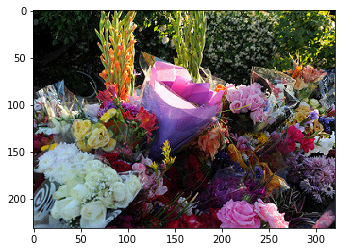

In [80]:
test_img_path = 'flower_photos/roses/10894627425_ec76bbc757_n.jpg'
test_img = imread(test_img_path)
plt.imshow(test_img)

In [81]:
# Run this cell if you don't have a vgg graph built
if 'vgg' in globals():
    print('"vgg" object already exists.  Will not create again.')
else:
    #create vgg
    with tf.Session() as sess:
        input_ = tf.placeholder(tf.float32, [None, 224, 224, 3])
        vgg = vgg16.Vgg16()
        vgg.build(input_)

"vgg" object already exists.  Will not create again.


In [83]:
with tf.Session() as sess:
    img = utils.load_image(test_img_path)
    img = img.reshape((1, 224, 224, 3))

    feed_dict = {input_: img}
    code = sess.run(vgg.relu6, feed_dict=feed_dict)
        
saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    feed = {inputs_: code}
    prediction = sess.run(predicted, feed_dict=feed).squeeze()
print("done")

done


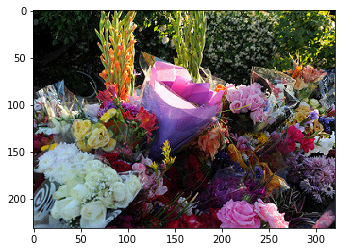

In [84]:
plt.imshow(test_img)

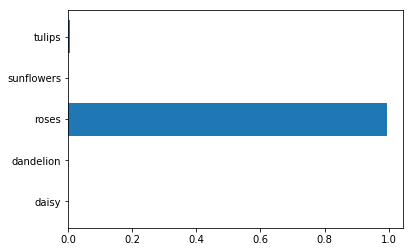

In [85]:
plt.barh(np.arange(5), prediction)
_ = plt.yticks(np.arange(5), lb.classes_)